In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))


%load_ext autoreload
%autoreload 2

/home/octav/gitrepos/tum-thesis


In [2]:
from otgnn.models import GCN
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer

from rdkit.Chem import MolFromSmiles

import torch
import numpy as np
import time

In [3]:
sys.argv = ["", "-cuda"]
args = get_args()
args.output_dir = "mol_opt/output/"

In [4]:
model = "transformer1"
model_iter = 1

model_name = "model_{}_{}".format(model, model_iter)
model_decode_name = "model_{}_decode_{}".format(model, model_iter)
molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
molopt, config

(MolOpt(
   (GCN): GCN(
     (W_message_i): Linear(in_features=100, out_features=50, bias=False)
     (W_message_h): Linear(in_features=50, out_features=50, bias=False)
     (W_message_o): Linear(in_features=143, out_features=50, bias=True)
     (W_mol_h): Linear(in_features=50, out_features=100, bias=True)
     (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
     (dropout_gcn): Dropout(p=0.0, inplace=False)
     (dropout_ffn): Dropout(p=0.0, inplace=False)
   )
   (opt0): Linear(in_features=50, out_features=50, bias=True)
   (opt1): Linear(in_features=50, out_features=50, bias=True)
 ),
 Namespace(N_transformer=6, agg_func='sum', batch_norm=False, cuda=True, device='cuda:0', dim_tangent_space=40, dropout_ffn=0.0, dropout_gcn=0.0, dropout_transformer=0.1, ffn_activation='LeakyReLU', init_decoder_model='transformer1_decode', init_model='transformer1', linear_out=False, n_epochs=40, n_ffn_hidden=100, n_ffn_transformer=100, n_heads_transformer=10, n_hidden=50, n_labels=1, n_

In [5]:
molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
molopt_decoder, config_decoder

(MolOptDecoder(
   (fc1_SYMBOLS): Linear(in_features=50, out_features=150, bias=True)
   (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
   (fc1_CHARGES): Linear(in_features=50, out_features=150, bias=True)
   (fc2_CHARGES): Linear(in_features=150, out_features=5, bias=True)
   (fc1_BONDS): Linear(in_features=100, out_features=150, bias=True)
   (fc2_BONDS): Linear(in_features=150, out_features=5, bias=True)
 ),
 Namespace(N_transformer=6, agg_func='sum', batch_norm=False, cuda=True, device='cuda:0', dim_tangent_space=40, dropout_ffn=0.0, dropout_gcn=0.0, dropout_transformer=0.1, ffn_activation='LeakyReLU', init_decoder_model='transformer1_decode', init_model='transformer1', linear_out=False, n_epochs=40, n_ffn_hidden=100, n_ffn_transformer=100, n_heads_transformer=10, n_hidden=50, n_labels=1, n_layers=5, ot_solver='emd', output_dir='mol_opt/output', pc_hidden=50, pred_hidden=150, sinkhorn_entropy=0.1, sinkhorn_max_it=10000))

In [6]:
train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train", 96, False)
val_data_loader = get_loader("iclr19-graph2graph/data/qed", "val", 96, False)

In [7]:
for i in val_data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

# Assess GCN

In [8]:
x_embedding, x_delta_hat = molopt.forward(X)
y_embedding = molopt.encode(Y)

In [9]:
x_embedding + x_delta_hat

tensor([[  6.1011, -17.3173,  -8.1689,  ...,   9.7493,  -8.2070, -14.2442],
        [ -0.5036,  -6.9928,   9.0679,  ...,  18.6350,  15.2381,  -5.0824],
        [  0.4959, -16.5815,   1.0548,  ...,  21.8699,   5.4606, -10.8815],
        ...,
        [-24.5036,   4.5038,  27.5806,  ...,  40.9691,  36.0237,   7.8554],
        [-17.5467,   7.8412,  26.1060,  ...,  37.6846,  32.5689,   9.6147],
        [  9.9412, -30.3590,   2.6873,  ...,  27.6739,  21.2154, -18.9911]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [10]:
y_embedding

tensor([[-0.0361, -0.0177,  0.0691,  ...,  0.0704, -0.0836,  0.0405],
        [-0.1923,  0.2669,  0.0355,  ...,  0.1362,  0.1356,  0.1779],
        [ 0.2283, -0.0384,  0.1441,  ..., -0.1121,  0.0645,  0.0371],
        ...,
        [-0.0809, -0.0752,  0.1038,  ...,  0.1667,  0.0061, -0.1234],
        [-0.0375,  0.4229, -0.0194,  ..., -0.0448, -0.0349,  0.0422],
        [-0.0617, -0.0700,  0.0009,  ...,  0.0454, -0.0325,  0.2737]],
       device='cuda:0', grad_fn=<CopySlices>)

In [11]:
x_embedding

tensor([[-0.0361, -0.0177,  0.0691,  ...,  0.0704, -0.0836,  0.0405],
        [-0.1923,  0.2669,  0.0355,  ...,  0.1362,  0.1356,  0.1779],
        [ 0.2283, -0.0384,  0.1441,  ..., -0.1121,  0.0645,  0.0371],
        ...,
        [-0.0809, -0.0752,  0.1038,  ...,  0.1667,  0.0061, -0.1234],
        [-0.0375,  0.4229, -0.0194,  ..., -0.0448, -0.0349,  0.0422],
        [-0.0617, -0.0700,  0.0009,  ...,  0.0454, -0.0325,  0.2737]],
       device='cuda:0', grad_fn=<CopySlices>)

In [12]:
x_delta_hat

tensor([[  6.1372, -17.2996,  -8.2380,  ...,   9.6789,  -8.1234, -14.2847],
        [ -0.3113,  -7.2597,   9.0324,  ...,  18.4988,  15.1025,  -5.2603],
        [  0.2677, -16.5431,   0.9107,  ...,  21.9820,   5.3961, -10.9186],
        ...,
        [-24.4227,   4.5791,  27.4769,  ...,  40.8024,  36.0176,   7.9788],
        [-17.5092,   7.4183,  26.1254,  ...,  37.7295,  32.6038,   9.5725],
        [ 10.0029, -30.2890,   2.6863,  ...,  27.6284,  21.2478, -19.2648]],
       device='cuda:0', grad_fn=<AddmmBackward>)

# Run all model, get some predictions

In [13]:
for idx, i in enumerate(val_data_loader):
    if idx == 1:
        X = (MolGraph(i[0]))
        Y = (MolGraph(i[1]))
        break

In [14]:
x_embedding, x_delta_hat = molopt.forward(X)
results_logits = molopt_decoder.forward(x_embedding + x_delta_hat, Y)
results_labels = molopt_decoder.discretize(*results_logits)

In [15]:
symbols_logits, charges_logits, bonds_logits = results_logits
symbols_labels, charges_labels, bonds_labels = results_labels

In [16]:
symbols_labels

tensor([0, 1, 1,  ..., 0, 0, 2], device='cuda:0', grad_fn=<NotImplemented>)

In [17]:
bonds_labels_arr = bonds_labels.cpu().numpy()

In [18]:
np.unique(bonds_labels_arr, return_counts=True)

(array([0, 1, 4]), array([ 9641,   246, 33727]))

In [19]:
target_symbols, target_bonds = encode_target(Y)
target_charges = target_symbols
target_symbols_labels, target_charges_labels, target_bonds_labels = molopt_decoder.discretize(target_symbols, target_charges, target_bonds)

In [20]:
print (np.unique(target_symbols_labels.cpu().numpy(), return_counts=True))
print (np.unique(symbols_labels.cpu().numpy(), return_counts=True))

(array([0, 1, 2, 3, 4, 7, 8]), array([1528,  207,  198,   34,   44,   23,    4]))
(array([ 0,  1,  2,  7, 51]), array([1631,  121,  155,  123,    8]))


In [21]:
print (np.unique(target_bonds_labels.cpu().numpy(), return_counts=True))
print (np.unique(bonds_labels.cpu().numpy(), return_counts=True))

(array([0, 1, 2, 4]), array([ 3170,  1178,     6, 39260]))
(array([0, 1, 4]), array([ 9641,   246, 33727]))


In [22]:
bonds_logits.shape

torch.Size([43614, 5])

In [23]:
lex = Y.scope[0][1]
bonds_logits.narrow(0,0,lex ** 2).view(lex, lex, 5)[:,:,0]

tensor([[ 6.3354,  5.1405,  8.5293,  6.3043,  6.1067,  7.6943,  4.9251,  5.2186,
          7.8682,  7.3559,  7.2288,  5.2859,  6.7322,  7.2201,  9.7022,  5.7299,
          7.7168,  6.6487,  4.1773,  6.5745, 10.1977,  8.1879],
        [ 5.1405,  5.1758,  8.4643,  5.4418,  6.7388,  8.2612,  4.8140,  4.5426,
          7.8491,  6.0311,  6.0868,  5.4523,  7.5747,  8.5516, 10.5646,  4.7835,
          8.3432,  5.6202,  4.4195,  7.2226,  9.7541,  7.9035],
        [ 8.5293,  8.4643, 10.8223,  8.1621,  8.5378,  9.8067,  7.5747,  7.4579,
         10.2907,  9.3061,  9.2053,  8.3591,  9.2259, 10.3475, 12.1734,  8.1404,
         10.5037,  8.9402,  6.9946,  9.3520, 12.2563, 10.5451],
        [ 6.3043,  5.4418,  8.1621,  6.8874,  8.0523,  9.5792,  5.6668,  4.7334,
          8.2318,  7.9529,  7.1471,  5.9850,  8.7211,  9.6162, 11.8414,  6.2263,
          9.1085,  6.5202,  4.2572,  8.1030,  9.4230,  8.2220],
        [ 6.1067,  6.7388,  8.5378,  8.0523,  7.7009,  9.0347,  7.0228,  6.7907,
          8.744

In [24]:
symbols_labels

tensor([0, 1, 1,  ..., 0, 0, 2], device='cuda:0', grad_fn=<NotImplemented>)

In [25]:
os.getcwd()

'/home/octav/gitrepos/tum-thesis'

# Visualize

In [26]:
from tensorboardX import SummaryWriter
tb_writer = SummaryWriter(logdir = "mol_opt/logs")

mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)

In [27]:
#preprocess
from rdkit import Chem
initial_smiles = [Chem.MolToSmiles(x) for x in X.rd_mols]
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]

labels = (symbols_labels, charges_labels, bonds_labels)
# labels = (target_symbols_labels, target_charges_labels, target_bonds_labels)
prediction = (labels, None, Y.scope)

In [28]:
symbols_labels.shape

torch.Size([2038])

In [29]:
sum([y for _, y in Y.scope])

2038

In [44]:
mol_drawer.visualize_batch(prediction, target_smiles, 1, initial_smiles)

0
could not find number of expected rings.
 RDKit drawing crashed while drawing PREDICTION!
smiles: COC1=CC=C(C[NH+]2CCN(C(=O)C3=CC=CO3)CC2)C=C1
prediction: C.C.CC12345C678C9%10%11%12%13N=C61%14%15%16%17%18%19=CCl92%1416%20%21%22%23%24%25CC%103129%14%26%27%28(C)C6C413(C)(C%152%20)(C%169%21)N%11%17%14%22C5%26%23(O7%121%18%27%24)O8%133%19%28%25


ValueError: could not find number of expected rings.

In [33]:
bond_idx = 1
for idx, (stx, lex) in enumerate(Y.scope):
    dev_sym = prediction[0][0].narrow(0, stx, lex).cpu().numpy()
    np.savetxt('symbols.txt', dev_sym, fmt='%i')
    np.savetxt('charges.txt', prediction[0][1].narrow(0, stx, lex).cpu().numpy(), fmt='%i')
    
    dev_bnd = prediction[0][2].narrow(0, bond_idx, lex*lex).view(lex, lex).cpu().numpy()
    np.savetxt('bonds.txt', dev_bnd, fmt='%i')
    bond_idx += lex * lex
    
    if idx == 0:
        break

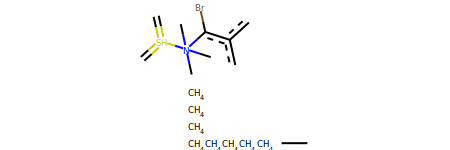

In [32]:
smiles = "C.C.C.C.C.C.C.C=S(=C)(=C)N(C)(C)(C)c(Br)c(c)c.CC"
smiles = "C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC"
from rdkit import Chem

from rdkit.Chem.Draw import IPythonConsole
Chem.MolFromSmiles(smiles, sanitize = False)

In [43]:
# Chem.MolFromSmiles("C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC")

In [379]:
smiles

'C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC'

In [380]:
bonds_labels

tensor([4, 4, 4,  ..., 4, 4, 4], device='cuda:0', grad_fn=<NotImplemented>)

In [381]:
dev_sym

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0])

In [38]:
mol = feat2smiles(SYMBOLS,None,BOND_TYPES,dev_sym, None, dev_bnd)

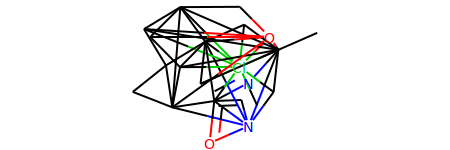

In [39]:
mol

In [35]:
for atom in mol.GetAtoms():
    print (atom.GetSymbol(), atom.GetFormalCharge(), atom.GetIsAromatic())

AttributeError: 'str' object has no attribute 'GetAtoms'

In [384]:
Chem.MolToSmiles(mol)

'C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.CC.CN.O.O'

In [341]:
Chem.MolToSmiles(Chem.MolFromSmiles(smiles))

'C.CCl'

In [342]:
Chem.MolFromSmiles(Chem.MolToSmiles(mol), sanitize = False)